Cost after iteration 0: 0.8716678345536438
Cost after iteration 1000: 0.2268181303866436
Cost after iteration 2000: 0.2143113200183979
Cost after iteration 3000: 0.19784237345139735
Cost after iteration 4000: 0.24761473263786948
Cost after iteration 5000: 0.18785167625218202
Cost after iteration 6000: 0.18480226837149508
Cost after iteration 7000: 0.1834184169777535
Cost after iteration 8000: 0.19576841518673124
Cost after iteration 9000: 0.1969695289931321
Cost after iteration 10000: 0.17875661021585196
Cost after iteration 11000: 0.1871262269693999
Cost after iteration 12000: 0.18217869895642544
Cost after iteration 13000: 0.1816316278893329
Cost after iteration 14000: 0.18021462739482044
Cost after iteration 15000: 0.17902916630241764
Cost after iteration 16000: 0.17788663513911504
Cost after iteration 17000: 0.17673090133079572
Cost after iteration 18000: 0.17581187669178575
Cost after iteration 19000: 0.17490576674588226
Cost after iteration 20000: 0.17406851315503966
Cost after i

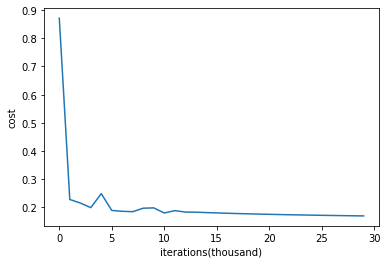

0.9210526315789473


In [20]:
"""
把各部分分离出来，降低耦合度，使得结构更加清晰
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import  load_breast_cancer
from sklearn.model_selection import train_test_split



#initialize parameters(w,b)
def initialize_parameters(layer_dims):
	"""
	:param layer_dims: list,每一层单元的个数（维度）
	:return:dictionary,存储参数w1,w2,...,wL,b1,...,bL
	"""
	np.random.seed(3)
	L = len(layer_dims)#the number of layers in the network
	parameters = {}
	for l in range(1,L):
		parameters["W" + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.1
		# parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2/layer_dims[l-1]) # he initialization
		# parameters["W" + str(l)] = np.zeros((layer_dims[l], layer_dims[l - 1])) #为了测试初始化为0的后果
		# parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(1 / layer_dims[l - 1])  # xavier initialization
		parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
	return parameters

def linear_forward(x, w, b):
	"""
	:param x:
	:param w:
	:param b:
	:return:
	"""
	z = np.dot(w, x) + b  # 计算z = wx + b
	return z

def relu_forward(Z):
	"""
	:param Z: Output of the activation layer
	:return:
	A: output of activation
	"""
	A = np.maximum(0,Z)
	return A

#implement the activation function(ReLU and sigmoid)
def sigmoid(Z):
	"""
	:param Z: Output of the linear layer
	:return:
	"""
	A = 1 / (1 + np.exp(-Z))
	return A

def forward_propagation(X, parameters):
	"""
	X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2",...,"WL", "bL"
                    W -- weight matrix of shape (size of current layer, size of previous layer)
                    b -- bias vector of shape (size of current layer,1)
    :return:
	AL: the output of the last Layer(y_predict)
	caches: list, every element is a tuple:(W,b,z,A_pre)
	"""
	L = len(parameters) // 2  # number of layer
	A = X
	caches = []
	# calculate from 1 to L-1 layer
	for l in range(1,L):
		W = parameters["W" + str(l)]
		b = parameters["b" + str(l)]
		#linear forward -> relu forward ->linear forward....
		z = linear_forward(A, W, b)
		caches.append((A, W, b, z))  # 以激活函数为分割，到z认为是这一层的，激活函数的输出值A认为是下一层的输入，划归到下一层。注意cache的位置，要放在relu前面。
		A = relu_forward(z) #relu activation function
	# calculate Lth layer
	WL = parameters["W" + str(L)]
	bL = parameters["b" + str(L)]
	zL = linear_forward(A, WL, bL)
	caches.append((A, WL, bL, zL))
	AL = sigmoid(zL)
	return AL, caches

#calculate cost function
def compute_cost(AL,Y):
	"""
	:param AL: 最后一层的激活值，即预测值，shape:(1,number of examples)
	:param Y:真实值,shape:(1, number of examples)
	:return:
	"""
	m = Y.shape[1]
	# cost = -1.0/m * np.sum(Y*np.log(AL)+(1-Y)*np.log(1.0 - AL))#py中*是点乘
	# cost = (1. / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T)) #推荐用这个，上面那个容易出错
	cost = 1. / m * np.nansum(np.multiply(-np.log(AL), Y) +
	                          np.multiply(-np.log(1 - AL), 1 - Y))
	#从数组的形状中删除单维条目，即把shape中为1的维度去掉，比如把[[[2]]]变成2
	cost = np.squeeze(cost)
	# print('=====================cost===================')
	# print(cost)
	return cost


#derivation of relu
def relu_backward(dA, Z):
	"""
	:param Z: the input of activation function
	:param dA:
	:return:
	"""
	dout = np.multiply(dA, np.int64(Z > 0)) #J对z的求导
	return dout

#derivation of linear
def linear_backward(dZ, cache):
	"""
	:param dZ: Upstream derivative, the shape (n^[l+1],m)
	:param A: input of this layer
	:return:
	"""
	A, W, b, z = cache
	dW = np.dot(dZ, A.T)
	db = np.sum(dZ, axis=1, keepdims=True)
	da = np.dot(W.T, dZ)
	return da, dW, db


def backward_propagation(AL, Y, caches):
	"""
	Implement the backward propagation presented in figure 2.
	Arguments:
	X -- input dataset, of shape (input size, number of examples)
	Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
	caches -- caches output from forward_propagation(),(W,b,z,pre_A)
	Returns:
	gradients -- A dictionary with the gradients with respect to dW,db
	"""
	m = Y.shape[1]
	L = len(caches) - 1
	#calculate the Lth layer gradients
	dz = 1. / m * (AL - Y)
	da, dWL, dbL = linear_backward(dz, caches[L])
	gradients = {"dW" + str(L + 1): dWL, "db" + str(L + 1): dbL}

	#calculate from L-1 to 1 layer gradients
	for l in reversed(range(0,L)): # L-1,L-3,....,0
		A, W, b, z = caches[l]
		#ReLu backward -> linear backward
		#relu backward
		dout = relu_backward(da, z)
		#linear backward
		da, dW, db = linear_backward(dout, caches[l])
		# print("========dW" + str(l+1) + "================")
		# print(dW.shape)
		gradients["dW" + str(l+1)] = dW
		gradients["db" + str(l+1)] = db
	return gradients

def update_parameters(parameters, grads, learning_rate):
	"""
	:param parameters: dictionary,  W,b
	:param grads: dW,db
	:param learning_rate: alpha
	:return:
	"""
	L = len(parameters) // 2
	for l in range(L):
		parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l+1)]
		parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l+1)]
	return parameters

def L_layer_model(X, Y, layer_dims, learning_rate, num_iterations):
	"""
	:param X:
	:param Y:
	:param layer_dims:list containing the input size and each layer size
	:param learning_rate:
	:param num_iterations:
	:return:
	parameters：final parameters:(W,b)
	"""
	costs = []
	# initialize parameters
	parameters = initialize_parameters(layer_dims)
	for i in range(0, num_iterations):
		#foward propagation
		AL,caches = forward_propagation(X, parameters)
		# calculate the cost
		cost = compute_cost(AL, Y)
		if i % 1000 == 0:
			print("Cost after iteration {}: {}".format(i, cost))
			costs.append(cost)
		#backward propagation
		grads = backward_propagation(AL, Y, caches)
		#update parameters
		parameters = update_parameters(parameters, grads, learning_rate)
	print('length of cost')
	print(len(costs))
	plt.clf()
	plt.plot(costs)  # o-:圆形
	plt.xlabel("iterations(thousand)")  # 横坐标名字
	plt.ylabel("cost")  # 纵坐标名字
	plt.show()
	return parameters

#predict function
def predict(X_test,y_test,parameters):
	"""
	:param X:
	:param y:
	:param parameters:
	:return:
	"""
	m = y_test.shape[1]
	Y_prediction = np.zeros((1, m))
	prob, caches = forward_propagation(X_test,parameters)
	for i in range(prob.shape[1]):
		# Convert probabilities A[0,i] to actual predictions p[0,i]
		if prob[0, i] > 0.5:
			Y_prediction[0, i] = 1
		else:
			Y_prediction[0, i] = 0
	accuracy = 1- np.mean(np.abs(Y_prediction - y_test))
	return accuracy

#DNN model
def DNN(X_train, y_train, X_test, y_test, layer_dims, learning_rate= 0.001, num_iterations=30000):
	parameters = L_layer_model(X_train, y_train, layer_dims, learning_rate, num_iterations)
	accuracy = predict(X_test,y_test,parameters)
	return accuracy

if __name__ == "__main__":
	X_data, y_data = load_breast_cancer(return_X_y=True)
	X_train, X_test,y_train,y_test = train_test_split(X_data, y_data, train_size=0.8,random_state=28)
#     print(X_train)
	X_train = X_train.T
#     print(X_train)
	y_train = y_train.reshape(y_train.shape[0], -1).T
#     print(y_train)
	X_test = X_test.T
#     print(X_test)
	y_test = y_test.reshape(y_test.shape[0], -1).T
	accuracy = DNN(X_train,y_train,X_test,y_test,[X_train.shape[0],10,5,1])
	print(accuracy)